<a href="https://colab.research.google.com/github/zaneprice5/knowledge-graph-with-spaCy/blob/main/NLP_Knowledge_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# This notebook will explore the NYT headlines dataset from https://www.kaggle.com/datasets/tmishinev/nyt-headlines-20102021?select=nyt_articles_2021.csv

We will mostly use sPacy https://spacy.io/ which is an industrial strength text-processing library to create a knowledge graph of the information contained in the NYT dataset.

Sources:
1. https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
2. https://spacy.io/

last updated: 10/2/2022

In [1]:
#import necessary libraries

import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [6]:
# read in data into pandas df
nyt_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nyt_articles_2021.csv")
nyt_data.shape

(37337, 7)

In [7]:
#inspect the data to understand its structure

nyt_data[16216:]

,pub_date,abstract,headline,lead_paragraph,news_desk,section_name,word_count
16216,2021-06-01 20:59:21+00:00,A look at one of the entries that fooled solvers in last week’s puzzles.,NaN,This article was published in error.,Games,Crosswords & Games,6
16217,2021-06-01 21:15:34+00:00,Return-to-office shots.,Coronavirus Briefing: What Happened Today,"As businesses prepare to bring employees back to the office in the coming months, their executives have been anxiously debating some thorny questions.",NYTNow,U.S.,953
16218,2021-06-01 21:25:48+00:00,"Homicide rates in large cities were up more than 30 percent on average last year, and up another 24 percent for the beginning of this year, according to criminologists.","With Homicides Rising, Cities Brace for a Violent Summer",The upbeat mood at an album release party at El Mula Banquet Hall in Miami-Dade County was shattered when three men in ski masks jumped out of a stolen white Nissan S.U.V. and fired randomly into ...,National,U.S.,1160
16219,2021-06-01 21:27:39+00:00,"Using cinematic tools other comics overlook, the star (who is also the director, editor and cameraman) trains a glaring spotlight on internet life mid-pandemic.",Bo Burnham’s ‘Inside’: A Comedy Special and an Inspired Experiment,"One of the most encouraging developments in comedy over the past decade has been the growing directorial ambition of stand-up specials. It’s folly to duplicate the feel of a live set, so why not f...",Culture,Arts,1155
16220,2021-06-01 21:33:23+00:00,"Leaders in the game noted that Osaka’s decision to bypass news conferences came as major media organizations had been cutting back on tennis coverage for years, a troubling dynamic for a sport tha...",Why the Grand Slam Tournaments Risked Playing Hardball With Naomi Osaka,"PARIS — The message was strong and swift, coming just hours after Naomi Osaka skipped a post-match news conference: If she did not start showing up for questioning, tennis officials would kick her...",Sports,Sports,1001
...,...,...,...,...,...,...,...
37332,2021-12-31 19:09:49+00:00,"People are waiting for rooms for days. At a homeless shelter in Brooklyn, 11 women with Covid were crammed into a single room.",Omicron is overwhelming New York’s quarantine hotel system.,"For much of the pandemic, one way New York City has tried to slow the coronavirus’s spread is by offering free hotel rooms to infected people who cannot easily isolate themselves from those they l...",Metro,New York,1174
37333,2021-12-31 19:45:59+00:00,"Every month, streaming services add movies and TV shows to their libraries. Here are our picks for some of January’s most promising new titles.","The Best Movies and TV Shows Coming to HBO, Hulu, Apple TV+ and More in January","(Note: Streaming services occasionally change schedules without giving notice. For more recommendations on what to stream, sign up for our Watching newsletter here.)",Culture,Arts,1171
37334,2021-12-31 20:10:10+00:00,"Cousins was placed on the team’s Covid-19 reserve list for at least five days, threatening Minnesota’s playoff chances.",Vikings quarterback Kirk Cousins tests positive in latest blow to the N.F.L. postseason race.,"Two days before the Minnesota Vikings face one of the best teams in the N.F.L., quarterback Kirk Cousins tested positive for the coronavirus and was placed on the team’s Covid-19 reserve list, a m...",Foreign,Sports,245
37335,2021-12-31 20:30:07+00:00,"Look back, look ahead.",What to Do This Weekend,Welcome. It’s New Year’s Eve and Omicron has put the brakes on any socially proximate revelry we may have had planned. We’re old pros by now at re-envisioning holidays — we’re old pros at re-envis...,AtHome,At Home,771


#### After looking at the dataframe, we see that we have 7 features. pub_date, abstract, headline, lead_paragraph, news_desk, section_name, and word_count. We can do quite a lot with this information!

### Let's explore creating a knowledge graph from the sentences contained in the dataset!

### Knowledge graphs are based upon nodes and edges. An edge connects two nodes and shows the relationship between them. The smallest possible knowledge graph we can build is called a 'triple.' A triple contains two nodes and an edge. 

An example of a triple would be (dog, to eat, bone). This triple may be encoded in a sentence like "The dog ate the bone yesterday."

#### The most basic way to construct a knowledge graph is to break a sentence down into its most basic constituents.

In [8]:
doc = nlp("the dog ate the bone yesterday.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
dog ... nsubj
ate ... ROOT
the ... det
bone ... dobj
yesterday ... npadvmod
. ... punct


Here we can see that spaCy is able to determine the syntactic constituency of all of the elements in the sentence. This will be important as we use a function to create the knowledge graph of sentences.

A popular text processing function in NLP is **entity extraction**. Many times you will also see this described as **named entity extraction** or **NER**. 

Your first approach to this might be identifying **parts of speech**. However, what about entities that span more than one token? In these cases, our NER parser would not be very accurate. Instead, we need to use **dependency parsing** which is where we consider syntactic dependencies to determine which tokens make up **entities** or **nouns/noun phrases**. 

These entities or noun phrases will be our **nodes** in the knowledge graphs we create. 


This function will extract the the noun phrases that receive **nominative case** (subjects) and other cases **(objects, vocatives, genitives, etc.)**.

In [9]:

# extract entities that can possibly span multiple tokens

# these entities will then be used to create our knowledge graphs.



def entity_extract(sequence):

  # instantiate our variables that will store the entities we parse
  ent1 = ""
  ent2 = ""

  # dependency tag of previous token in the sentence
  prv_tok_dep = ""   

  # previous token in the sentence 
  prv_tok_text = ""   

  prefix = ""
  modifier = ""

  
  ## this for loop iterates through the labels that spaCy assigns to each token in the sequence. 
  for tok in nlp(sequence):
    
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check whether token is a modifier
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      # check for subject
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      # check for object
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [10]:
#now we can test the function on a sequence. 

entity_extract('the dog ate five bones.')

['dog', 'five  bones']

We can see that the entity extractor does what we need it to do! In fact, we can see that it was able to combine the modifier of 'bones' with 'five'. This is exactly what we need.

In [16]:
%time
#Now let's use our function to run through all of the headlines in the New York Times data!

#help(nyt_data.loc()) #remind myself what I can pass to 'loc()'

#instantiate a list to store our pairs of entities. 
entities = []
#tell loc() what column I want to iterate through. I can also use iloc(), where we would have to pass integer index instead of column title.

#this throws an error because there are hidden 'float' types. Convert all to string within the function with 'str()'

pairs = nyt_data.loc[0:5000, 'headline'].apply(lambda x: entity_extract(str(x)))

#take all of our entities pairs and throw into our list!
for i in pairs:
  entities.append(i)
  

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [18]:
#we should lowercase our strings
#use pythonic list comp!

entities = [[x.casefold() for x in sublst] for sublst in entities]


#check out our extracted entities
entities[300:350]



[['this', ''],
 ['how  you', 'downtime'],
 ['', 'stethoscope'],
 ['', 'beauty boost'],
 ['', 'shrimp times'],
 ['why  fight', 'hunger games'],
 ['', 'how grim winter'],
 ['', 'georgia senate what'],
 ['restaurant workers', 'toxic covid'],
 ['it', 'better tv room'],
 ['how  you', 'cartagena'],
 ['2 georgia i', 'zero vote'],
 ['indonesians', 'answer'],
 ['', 'questionable stock lawmakers'],
 ['conspiracy police', 'vaccine doses'],
 ['who', 'georgia'],
 ['core', 'race'],
 ['it', 'fateful  georgia'],
 ['', 'broader vietnam speech'],
 ['', 'stock trades'],
 ['investors', 'colorado river'],
 ['d.c. braces', 'two proud boys'],
 ['runoffs', ''],
 ['different  we', 'different  election'],
 ['gulf states', 'end qatar'],
 ['canadian  website', 'small  businesses'],
 ['pence', 'choice'],
 ['', ''],
 ['', 'treating mental illness'],
 ['art world', '2021  pencil'],
 ['who', 'quietly georgia election'],
 ['new york city', 'grim  igloos'],
 ['', 'rare move'],
 ['polls', 'runoff elections'],
 ['one hos

We can see that all of the entities pairs aren't perfect. In lots of cases, it returns a list with maybe only one entity. No big deal though, we should still be able to create a reasonably explanatory knowledge graph.

The entity_extract function could probably use some work to catch more of these fringe cases. 

Now we have to **connect the nodes** to actually create our **knowledge graphs**

The following function captures **predicates** **(verbs)** using spaCy's **rule-based matching**

In [19]:
def relation_extract(sequences):

  doc = nlp(sequences)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #hand-define our structures
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match = None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [25]:
#test out our function on simple sequence

relation_extract('The driver went to the store')

'went to'

In [26]:
relations = [relation_extract(i) for i in nyt_data.loc[:5000, 'headline']]

In [28]:
#lowercase our relations

relations = [x.casefold() for x in relations]

#check that the verbs were appended to our list

relations[:20]

['video of',
 'resolving',
 'asks',
 'reaches',
 'hearty',
 'include',
 'happening',
 'detect',
 'laments',
 'date',
 'moving',
 'york to',
 'is',
 'need',
 'keeps',
 'ways',
 'teaching',
 'confessions of',
 'keep',
 'endure']

Now we should check out which verbs are most frequent!


In [29]:
pd.Series(relations).value_counts()[:10] #top 10 verbs!

is          133
says        104
’s           86
say          54
are          49
was          36
briefing     34
has          27
in           25
said         22
dtype: int64

## Now we can construct the knowledge graph with the data that we have collected. 

In [30]:
#extract the source or the subject

subject = [i[0] for i in pairs]

#extract object

recipient = [i[1] for i in entities]

#create our dataframe with the nodes and edge. 

knowledge_df = pd.DataFrame({'subject': subject, 'recipient': recipient, 'edge': relations})

Let's use the networkx library to make the knowledge network from the df. 

In [31]:
# create a directed-graph from a dataframe
graph = nx.from_pandas_edgelist(knowledge_df, "subject", "recipient", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let's check out a rough plot of the graph!

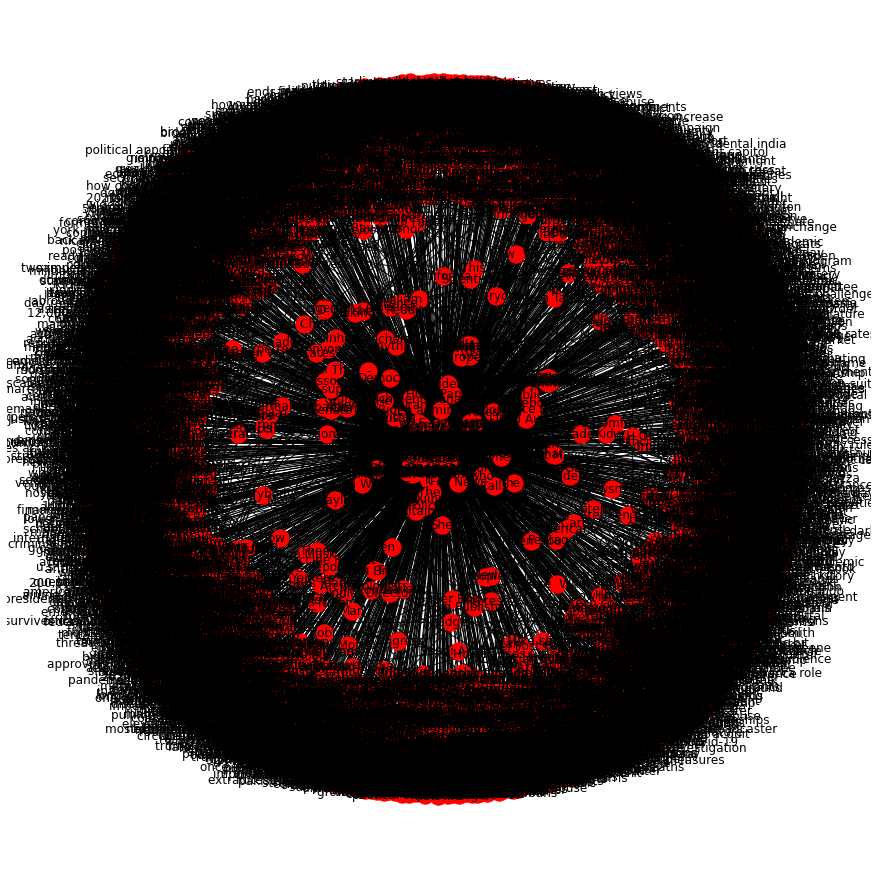

In [32]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(graph)
nx.draw(graph, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#this makes a huge graph!!

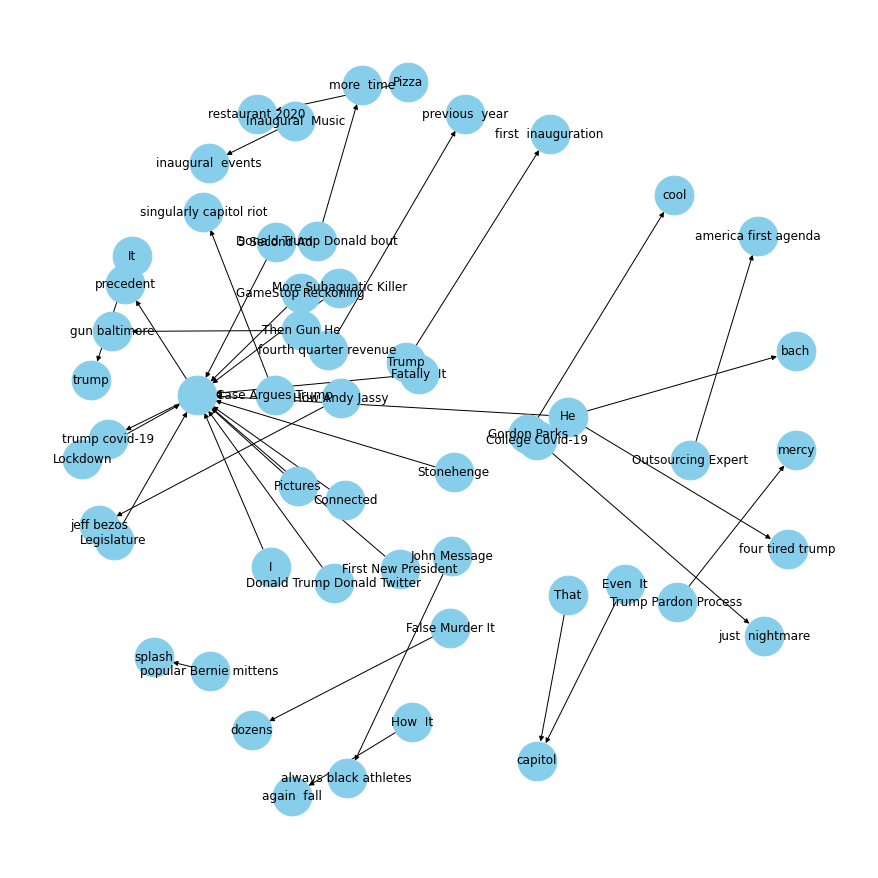

In [34]:
#let's go with a more concise graph. 

graph = nx.from_pandas_edgelist(knowledge_df[knowledge_df['edge']=="was"], "subject", "recipient", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(graph, k = 0.5) # k adjusts distance between the nodes
nx.draw(graph, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

#this is kinda interesting!
